## Exploring Alzheimer's: Cognitive Decline and Mental Distress through the Lens of GridDB

A progressive brain disorder, Alzheimer's disease often leads to the degeneration of brain cells. It is the most common cause of dementia, characterized by memory loss, cognitive decline, and behavioral changes. Being a brain disorder, Alzheimer's disease gradually impairs one's ability to perform daily activities. If you’ve watched the award-winning movie 'Still Alice', you will know how deep is the personal impact of Alzheimer's disease. While risk factors of Alzheimer's include age, genetics, and lifestyle choices, it is crucial to delve deeper to understand and manage the symptoms effectively. 

In this article, we will perform a comprehensive analysis of Alzheimer's risk factors using GridDB and Python. By leveraging GridDB’s robust data management and analytical capabilities, researchers can efficiently analyze large datasets, uncover valuable insights, and better understand the patterns and correlations associated with Alzheimer's disease. In this case, we use the GridDB WebAPI. To learn more, refer to the <a href = "https://github.com/griddb/webapi"> official Web API - GridDB resource. </a>

In [44]:
#Libraries for basic data manipulation
import os
import pandas as pd
import numpy as np

#Libraries for the webAPI requests
import http
http.client.HTTPConnection.debuglevel = 0
import json
import requests

import pyarrow as pa
import pyarrow.csv as csv
import time

## Setting
from IPython.display import Image, Markdown,HTML, display
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
os.environ['OMP_NUM_THREADS'] = '1' # to run KMeans clustering without memory leak issues

# Visualizations & Unsupervised Learning
import folium
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re  # Importing the regex module for parsing
import json

# Mention your working directory here
os.chdir("C:\\XX\\")

## About the Dataset

The dataset being used is from the U.S. Department of Health & Human Services. To access the dataset, navigate to the URL - https://catalog.data.gov/dataset/alzheimers-disease-and-healthy-aging-data. Use the 'Comma Separated Values' option to download the .csv file.

### Downloading the Alzheimers' Dataset

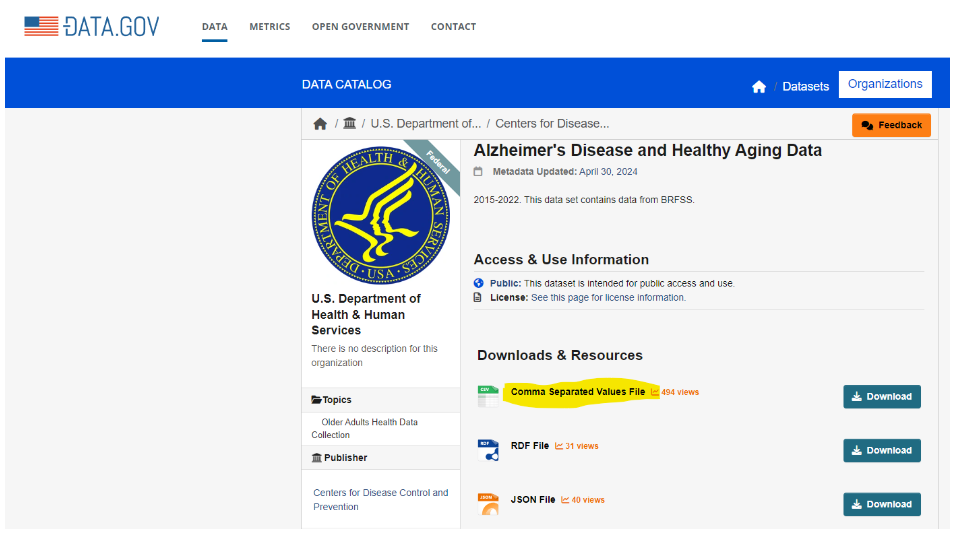

In [4]:
# Specify the path to your image file
current_directory = os.getcwd()

# Construct the image path using os.path.join()
image_path = os.path.join(current_directory, 'Intro_Fig2.Dowloading the Alzheimers dataset.png')

width = 700

display(Markdown("### Downloading the Alzheimers' Dataset"))

# Display the image
display(Image(filename=image_path, width=width))

The **Alzheimer's Disease and Healthy Aging Data** dataset is a comprehensive resource compiled by the CDC. It focuses on the health and well-being of older Americans and includes a wide range of data on demographics, health conditions, and behaviors. The dataset is sourced from national surveys like BRFSS, NHANES, and NHIS. It emphasizes Alzheimer's disease, covering prevalence, incidence, risk factors, and outcomes. This data is valuable for identifying trends and exploring risk factors related to Alzheimer's. It is also useful in identifying at-risk populations and tracking the effectiveness of public health interventions for older adults.

### Dataset Columns
<ul>
<li> RowId: A unique identifier for each row in the dataset, used to distinguish between different records. </li>

<li> YearStart: The starting year in which the data was collected. This helps in identifying the time period of the data. </li>

<li> YearEnd: The ending year of data collection. It is usefli for datasets that span mlitiple years. </li>

<li> LocationAbbr: The abbreviation for the geographic location (e.g., state or territory). This allows quick identification of where the data was collected. </li>

<li> LocationDesc: A description or flil name of the location corresponding to the abbreviation, providing more detailed information about the location. </li>

<li> Datasource: The source from which the data was collected (e.g., Behavioral Risk Factor Surveillance System (BRFSS)). This helps in understanding the origin and context of the data. </li>

<li> Class: The broad category of health information that the data point belongs to (e.g., Mental Health). It groups related data points together. </li>

<li> Topic: A more specific subject within the class (e.g., Frequent mental distress). This narrows down the focus within the broader class. </li>

<li> Question: The specific question asked during data collection or the metric being measured (e.g., "In the past 30 days, how often did you feel mentally distressed?"). This provides context for the data values. </li>

</ul>

## Containers in GridDB

In GridDB, there are two types of containers: **Time-Series Containers**, designed for storing time-stamped data and optimized for time-based queries, and **Collection Containers**, which are more flexible and can hold various data types without time constraints, allowing for general-purpose data storage and retrieval.

**Choosing a Collection Container over a Time-Series Container** may be preferable when you require greater flexibility in data structure or would need to store heterogeneous data types. In this case, we will be using a 'Collection' container. Hence, in this case, we will store our data in a Collection Container. Here is a <a href = "https://docs.griddb.net/architecture/data-model/"> useful resource </a> to better understand the GridDB model architecture.

## Creating a Data Structure for the Container in GridDB

The dataset is first loaded into Python as a dataframe. It is then loaded into a GridDB 'Collection' container. We create a function to map out the datatypes from the dataframe to the structure required for a Collection container in GridDB.

In [ ]:
#Read the CSV dataset file that was downloaded in the earlier step
Alzheimer_Data = pd.read_csv('../Alzheimer_s_Disease_and_Healthy_Aging_Data.csv')

In [ ]:
#Subset the data to include the data that we want to use
Alzheimer_subset = Alzheimer_Data[
    (Alzheimer_Data['Topic'] == 'Frequent mental distress') |
    (Alzheimer_Data['Topic'].str.contains('Cognitive Decline', case=False, na=False))]

In [ ]:
# Defining a function to map pandas dtypes to GridDB types
def map_dtype_to_griddb(pandas_dtype):
    """
    # Maps pandas data types to GridDB-compatible data types.
    e.g. pandas_dtype (str): Data type of a pandas column; Returns str: The corresponding GridDB data type.
    """
    dtype_map = {
        'int64': 'INTEGER',
        'float64': 'DOUBLE',
        'object': 'STRING',  # for strings/objects
        'datetime64[ns]': 'TIMESTAMP',
        'bool': 'BOOL'
    }
    return dtype_map.get(str(pandas_dtype), 'STRING')  # Default to STRING if no match

# Function to create the GridDB collection structure from a DataFrame
def create_griddb_structure(df, container_name, container_type="COLLECTION", rowkey=False):
    # Initializing the container structure
    container_structure = {
        "container_name": container_name,
        "container_type": container_type,
        "rowkey": rowkey,
        "columns": []
    }

    # Looping through columns in the DataFrame and mapping their data types to GridDB types
    for col_name, col_dtype in df.dtypes.items():
        column_structure = {
            "name": col_name,
            "type": map_dtype_to_griddb(col_dtype)
        }
        container_structure["columns"].append(column_structure)
    
    return container_structure



In [ ]:
# Create the GridDB container structure
griddb_container_structure = create_griddb_structure(Alzheimer_subset, "Alzheimer_Analysis", container_type="COLLECTION")

data_obj1 = griddb_container_structure

## Connecting to GridDB using WebAPI

We use the WebAPI to connect to GridDB. When using the WebAPI, we can make HTTP requests with the 'requests' library in Python to interact with the GridDB cluster. To create a container using the WebAPI, we'll need to send a POST request with a JSON payload that defines the container's structure.
If you are interested in learning about the setup of the WebAPI, refer to these pages from the Github repo - <a href= "https://github.com/griddb/webapi"> WebAPI </a>.

In [6]:
#Construct an object to hold the request headers (ensure that you replace the XXX placeholder with the correct value that matches the credentials for your GridDB instance)
header_obj = {"Authorization":"Basic XXX","Content-Type":"application/json; charset=UTF-8","User-Agent":"PostmanRuntime/7.29.0"}

#Construct the base URL based on your GridDB cluster you'd like to connect to (ensure that you replace the placeholders in the URL below with the correct values that correspond to your GridDB instance)
base_url = 'https://[host]:[port]/griddb/v2/[clustername]/dbs/[database_name]/'

## Running the Request to create a GridDB container

In [ ]:
#Set up the GridDB WebAPI URL
url = base_url + 'containers'

#Invoke the GridDB WebAPI with the headers and the request body (constructed in the earlier step)
x = requests.post(url, json = data_obj1, headers = header_obj)

## Loading the Container with Data (Row Registration)

The process of loading data into a container is also known as <b> 'Row Registration' </b>. To read more about it, refer to the GridDB resource <a href = "http://www.toshiba-sol.co.jp/en/pro/griddb/docs-en/v4_3/GridDB_Web_API_Reference.html#%E3%83%AD%E3%82%A6%E7%99%BB%E9%8C%B2"> here</a>. We use the 'to_json' function in the Pandas library to construct the JSON structure required for row registration.

In [ ]:
# Step 1: Convert the DataFrame to a JSON format with column names (key-value pairs)
Alzheimer_subset_json = Alzheimer_subset.to_json(orient='values')

# Parse the JSON string into a Python list of dictionaries
request_body_Alzheimer_Data = Alzheimer_subset_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + 'containers/Alzheimer_Analysis/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_Alzheimer_Data, headers=header_obj)

## Mental Distress by State

### Top 10 locations with the highest percentages of frequent mental distress recorded.

The query below fetches the top 10 locations based on the highest percentage of frequent mental distress records in the Alzheimer_Analysis table, calculating the percentage as a fraction of the total number of records for each location.
As you can see, GridDB supports CASE WHEN statements, string matching and aggregate functions. Refer to this <a href = "https://griddb.org/docs-en/manuals/GridDB_SQL_Reference.html#sql-commands-supported-by-griddb"> official GridDB resource </a> to know more. 

In [7]:
sql_query1 = (f"""
                SELECT LocationDesc, Geolocation,
                       (COUNT(CASE
                       WHEN LOWER(Topic) LIKE '%distress%' THEN 1
                       END
                             ) * 100.0 / COUNT(*)
                       ) AS Percentage_Frequent_Mental_Distress
                FROM Alzheimer_Analysis
                GROUP BY LocationDesc, Geolocation
                ORDER BY Percentage_Frequent_Mental_Distress DESC
                LIMIT 10;
        """)

In [8]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + 'sql'

# Construct the request body
request_body = json.dumps([
    {
        "type": "sql-select",
        "stmt": sql_query1
    }
])

# Validate the constructed request body
#print(request_body)

In [9]:
#Invoke the GridDB WebAPI
data_req1 = requests.post(url, data=request_body, headers=header_obj)

In [10]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req1.json()
Mental_Distress_by_state = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"]])

In [11]:
# Ensure the Geolocation column is of type string and handle NaN values
Mental_Distress_by_state['Geolocation'] = Mental_Distress_by_state['Geolocation'].astype(str)

# Extract latitude and longitude from Geolocation column
Mental_Distress_by_state['Longitude'] = Mental_Distress_by_state['Geolocation'].apply(
    lambda x: float(x.split(' ')[1].strip('()')) if isinstance(x, str) and 'POINT' in x else None
)  # Longitude

Mental_Distress_by_state['Latitude'] = Mental_Distress_by_state['Geolocation'].apply(
    lambda x: float(x.split(' ')[2].strip('()')) if isinstance(x, str) and 'POINT' in x else None
)  # Latitude


# Create a map centered around the United States
us_latitude = 37.0902  # Latitude for the U.S. center
us_longitude = -95.7129  # Longitude for the U.S. center

# Create a map centered around the United States, filtering out any NaN values
valid_locations = Mental_Distress_by_state.dropna(subset=['Latitude', 'Longitude'])
if not valid_locations.empty:
    m = folium.Map(location=[us_latitude, us_longitude], zoom_start=4)  # Adjust zoom level as needed

    # Add markers to the map
    for idx, row in valid_locations.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"{row['LocationDesc']}<br>Percentage: {row['Percentage_Frequent_Mental_Distress']}%",
            tooltip=row['LocationDesc']
        ).add_to(m)

    # Display the title above the map
    display(Markdown("## Mental Distress by State - Geographical Distribution"))

    # Display the states with markers
    states_with_markers = ', '.join(valid_locations['LocationDesc'].tolist())
    display(Markdown(f"**Top States with people reporting Frequent Mental Distress:** {states_with_markers}"))

    # Display the map in Jupyter Notebook directly
    display(m)
else:
    print("No valid locations to display.")


## Mental Distress by State - Geographical Distribution

**Top States with people reporting Frequent Mental Distress:** Virgin Islands, Guam, Montana, Massachusetts, West Virginia, North Dakota, South Dakota, Wyoming, New Hampshire, Kentucky

## Cognitive Decline by State

In the query below, we use a subquery or nested query style. The outer query/main query selects LocationDesc, Geolocation, and Data_Value (renamed as Cognitive_Decline_Percentage) from the Alzheimer_Analysis table, where the Topic is related to "Cognitive Decline" and the Data_Value exceeds a certain threshold. The inner query calculates the average of Data_Value for records where either Class or Topic contains "cognitive decline". The result of this subquery is then used as the threshold in the outer query. This style is commonly used in relational database queries when we are required to compare values in a dataset against an aggregate function (like an average) or a calculated result. Refer to <a href = "https://griddb.org/docs-en/manuals/GridDB_SQL_Reference.html#where"> this resource </a> to learn more.

In [12]:
sql_query2 = (f"""
				SELECT LocationDesc, Geolocation,Data_Value as Cognitive_Decline_Percentage
				FROM Alzheimer_Analysis
				WHERE Topic LIKE '%Cognitive Decline%'
				AND Data_Value > (
					SELECT AVG(Data_Value)
					FROM Alzheimer_Analysis
					WHERE (LOWER(Class) LIKE '%cognitive decline%'
                    OR LOWER(Topic) LIKE '%cognitive decline%')
				);
        """)

In [14]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + 'sql'

# Construct the request body
request_body = json.dumps([
    {
        "type": "sql-select",
        "stmt": sql_query2
    }
])

# Validate the constructed request body
#print(request_body)

#Invoke the GridDB WebAPI
data_req2 = requests.post(url, data=request_body, headers=header_obj)

#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req2.json()
Cognitive_Decline = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"]])

Since the 'LocationDesc' has both states and broader regions in the US (like West, Northeast, etc.), we create a separate column to map out individual states to broader U.S. regions.

In [15]:
# Mapping of states and regions
state_to_region = {
    'Idaho': 'West', 
    'Arizona': 'West', 
    'Oklahoma': 'South', 
    'Tennessee': 'South',
    'South': 'South', 
    'Kentucky': 'South', 
    'Wyoming': 'West', 
    'Maryland': 'Northeast',
    'Midwest': 'Midwest', 
    'West': 'West', 
    'Arkansas': 'South', 
    'Delaware': 'Northeast', 
    'Illinois': 'Midwest', 
    'Rhode Island': 'Northeast', 
    'Connecticut': 'Northeast', 
    'Washington': 'West', 
    'Pennsylvania': 'Northeast', 
    'Texas': 'South', 
    'Oregon': 'West', 
    'Ohio': 'Midwest', 
    'Georgia': 'South', 
    'New Jersey': 'Northeast', 
    'New Mexico': 'West', 
    'New York': 'Northeast', 
    'South Carolina': 'South', 
    'United States, DC & Territories': 'DC & Territories',
    'California': 'West', 
    'Michigan': 'Midwest', 
    'Virginia': 'South', 
    'District of Columbia': 'Northeast', 
    'South Dakota': 'Midwest', 
    'Hawaii': 'West', 
    'Indiana': 'Midwest', 
    'Vermont': 'Northeast', 
    'Iowa': 'Midwest', 
    'Kansas': 'Midwest', 
    'New Hampshire': 'Northeast', 
    'Utah': 'West', 
    'Alabama': 'South', 
    'Nevada': 'West', 
    'Louisiana': 'South', 
    'Maine': 'Northeast', 
    'Nebraska': 'Midwest', 
    'Alaska': 'West', 
    'Mississippi': 'South', 
    'Wisconsin': 'Midwest', 
    'North Carolina': 'South', 
    'West Virginia': 'South', 
    'Florida': 'South', 
    'Missouri': 'Midwest', 
    'North Dakota': 'Midwest', 
    'Minnesota': 'Midwest', 
    'Colorado': 'West', 
    'Montana': 'West', 
    'Massachusetts': 'Northeast', 
    'Puerto Rico': 'DC & Territories',
    'Guam': 'DC & Territories', 
    'U.S. Virgin Islands': 'DC & Territories', 
    'American Samoa': 'DC & Territories',
    'Northern Mariana Islands': 'DC & Territories', 
    'Midway Atoll': 'DC & Territories', 
    'Baker Island': 'DC & Territories',
    'Howland Island': 'DC & Territories',
    'Jarvis Island': 'DC & Territories',
    'Johnston Atoll': 'DC & Territories',
    'Kingman Reef': 'DC & Territories',
    'Palmyra Atoll': 'DC & Territories'
}

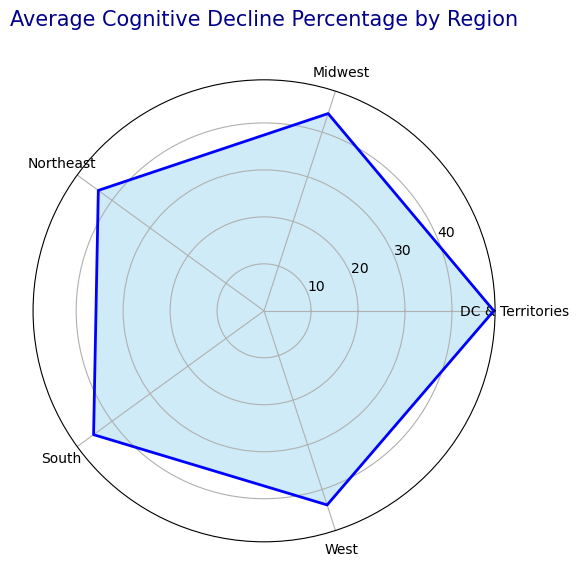

In [16]:
# Step 1: Create a Region Column in Cognitive_Decline DataFrame
Cognitive_Decline['Region'] = Cognitive_Decline['LocationDesc'].map(state_to_region)

# Step 2: Aggregate the data by Region
region_data = Cognitive_Decline.groupby('Region')['Cognitive_Decline_Percentage'].mean().reset_index()

# Step 3: Extract Data for Plotting
categories = region_data['Region']
values = region_data['Cognitive_Decline_Percentage']

# Handle NaN values if any
values = values.fillna(0)

# Number of categories
N = len(categories)

# Creating a list of angles for the plot
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
values = values.tolist()

# Ensure the plot is circular
angles += angles[:1]
values += values[:1]

# Initializing the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plotting the data
ax.fill(angles, values, color='skyblue', alpha=0.4)
ax.plot(angles, values, color='blue', linewidth=2)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

plt.title('Average Cognitive Decline Percentage by Region', size=15, color='darkblue', y=1.1)
plt.show()

<b>Insight(s):</b> The United States, DC & Territories comprised of Washington D.C (District of Columbia), Puerto Rico, Guam, U.S. Virgin Islands, American Samoa, and Northern Mariana Islands have the highest Cognitive Decline across all regions. The Cognitive Decline percentage is higher than the average cognitive decline across the United States.

Similarly, the Midwest comprising  Illinois, Ohio, Michigan, Indiana, South Dakota, Iowa, Kansas, Nebraska, Wisconsin, Missouri, North Dakota, Minnesota also faces a higher than average cognitive decline.

To determine why the DC & territories have a higher than average Cognitive Decline, we analyze the socioeconomic and demographic factors in this region.

## Analyzing the factors contributing to Cognitive Decline (in DC and Union Territories) 

The SQL query below is an example of a **complex join query** with **subqueries** or **nested queries** (also known as **derived tables**). In addition, the query uses `CASE` statements to standardize the age group and to filter out irrelevant data, which is useful for grouping similar records.
The query also uses **Conditional Filters**, **multiple grouping levels** and **aggregation functions** (like `AVG`). To learn more on JOINS, refer to the <a href="https://griddb.org/docs-en/manuals/GridDB_SQL_Reference.html#join"> resource here. </a>

In [17]:
sql_query3 = (f"""  
			SELECT
				Table_A.LocationDesc,
				Table_A.Geolocation,
				Table_A.Age_Group,
				Table_A.Gender,
				Table_B.Race_Ethnicity,
				Table_A.Cognitive_Decline_Percentage AS Gender_based_Cognitive_Decline,
				Table_B.Cognitive_Decline_Percentage AS Ethnicity_based_Cognitive_Decline
				FROM
					(SELECT 
                    LocationDesc,
                    Geolocation,
                    CASE 
                        WHEN Stratification1 = '50-64 years' THEN '50-64 years'
                        WHEN Stratification1 = '65 years or older' THEN '65 years or older'
                        ELSE 'Overall'
                    END AS Age_Group,
                    (CASE 
                        WHEN StratificationCategory2 = 'Gender' THEN Stratification2 
                        ELSE NULL
                    END) AS Gender,
					AVG(Data_Value) AS Cognitive_Decline_Percentage
					FROM 
						Alzheimer_Analysis
					WHERE 
						Stratification1 IN ('50-64 years', '65 years or older')
						AND 
						Class LIKE '%Cognitive Decline%'
						AND LocationDesc IN ('District of Columbia', 'Puerto Rico', 'Guam', 'Virgin Islands', 'American Samoa', 'Northern Mariana Islands')
						AND (StratificationCategory2 <> '' AND StratificationCategory2 IS NOT NULL)
						AND StratificationCategory2 = 'Gender'
					GROUP BY 
						LocationDesc,
						Geolocation,
						Age_Group,
						Gender
					ORDER BY 5 DESC
					) Table_A
					INNER JOIN
					 (SELECT 
						LocationDesc,
						Geolocation,
						CASE 
							WHEN Stratification1 = '50-64 years' THEN '50-64 years'
							WHEN Stratification1 = '65 years or older' THEN '65 years or older'
							ELSE 'Overall'
						END AS Age_Group,
						(CASE 
							WHEN StratificationCategory2 = 'Race/Ethnicity' THEN Stratification2 
						END) AS Race_Ethnicity,
						AVG(Data_Value) AS Cognitive_Decline_Percentage
					FROM 
						Alzheimer_Analysis
					WHERE 
						Stratification1 IN ('50-64 years', '65 years or older')
						AND 
						Class LIKE '%Cognitive Decline%'
						AND LocationDesc IN ('District of Columbia', 'Puerto Rico', 'Guam', 'Virgin Islands', 'American Samoa', 'Northern Mariana Islands')
						AND (StratificationCategory2 <> '' AND StratificationCategory2 IS NOT NULL)
						AND StratificationCategory2 = 'Race/Ethnicity'
					GROUP BY 
						LocationDesc,
						Geolocation,
						Age_Group,
						Race_Ethnicity
					ORDER BY 5 DESC
					) Table_B
				  on Table_A.LocationDesc = Table_B.LocationDesc
					AND Table_A.Geolocation = Table_B.Geolocation
					AND Table_A.Age_Group = Table_B.Age_Group           
				""")

In [18]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + 'sql'

# Construct the request body
request_body = json.dumps([
    {
        "type": "sql-select",
        "stmt": sql_query3
    }
])

#Invoke the GridDB WebAPI
data_req3 = requests.post(url, data=request_body, headers=header_obj)

In [19]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req3.json()
Cognitive_Decline_Indicators = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][i]["name"] for i in range(7)])

We use the resulting data to determine the Gender based Cognitive Decline and the Ethnicity based Cognitive Decline.

### Gender based Cognitive Decline

In [20]:
def plot_gender_based_cognitive_decline(df):
    # Pivot the data to make it easier for plotting
    gender_pivot = Cognitive_Decline_Indicators.pivot_table(index=['LocationDesc', 'Age_Group'], columns='Gender', values='Gender_based_Cognitive_Decline')

    # Plotting the stacked bar chart
    ax = gender_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])

    # Loop through the bars to add percentage annotations
    for container in ax.containers:
        # Add annotations
        ax.bar_label(container, fmt='%.1f%%', label_type='center')

    # Labels and Titles
    plt.title('Gender-Based Cognitive Decline by Location and Age Group')
    plt.xlabel('Location and Age Group')
    plt.ylabel('Cognitive Decline Percentage')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Gender')
    plt.tight_layout()

    plt.show()

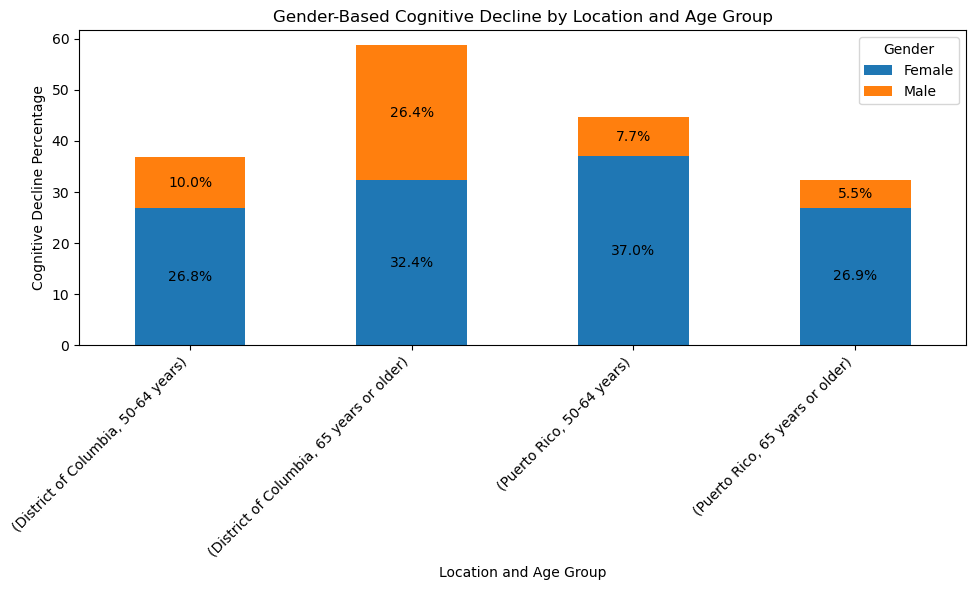

In [21]:
plot_gender_based_cognitive_decline(Cognitive_Decline_Indicators)

<b> Insight(s) : </b> Women seem to be suffering more from Cognitive Decline compared to men. This is observed more in the District of Columbia and Puerto Rico.

### Ethnicity based Cognitive Decline

In [22]:
ethnicity_pivot = Cognitive_Decline_Indicators.pivot_table(index=['LocationDesc', 'Age_Group'], columns='Race_Ethnicity', values='Ethnicity_based_Cognitive_Decline', aggfunc='first')

# Applying heatmap-like styling with a gradient from white to green
ethnicity_pivot_styled = ethnicity_pivot.style.background_gradient(cmap='Greens')

# Display the table in Jupyter Notebook (won't display directly in scripts, but will render in Jupyter)
ethnicity_pivot_styled

<b> Insight(s): </b> We see that people of Hispanic origin who are 65 years or older and in Puerto Rico have a relatively high percentage of Cognitive Decline.

## Evaluating the Impact of Subjective Cognitive Decline on Social Activities: A State-Level Overview by Age and Gender

GridDB supports commonly found operators such as the IN Clause and special handling operators such as COALESCE. In this case, we gather the gender, location, geolocation and average percentage of cognitive decline for specific questions asked to respondents.

In [23]:
sql_query4 = (f"""  
            SELECT
                Stratification2 AS Gender,
                LocationDesc AS Location,
                Geolocation,
                Question,
                COALESCE(AVG(Data_Value),0) AS Avg_Percentage
            FROM
                Alzheimer_Analysis
            WHERE
                Question IN (
                    'Percentage of older adults who are experiencing frequent mental distress',
                    'Percentage of older adults who reported subjective cognitive decline or memory loss that interferes with their ability to engage in social activities or household chores',
                    'Percentage of older adults with subjective cognitive decline or memory loss who reported talking with a health care professional about it',
                    'Percentage of older adults who reported subjective cognitive decline or memory loss that is happening more often or is getting worse in the preceding 12 months',
                    'Percentage of older adults who reported that as a result of subjective cognitive decline or memory loss that they need assistance with day-to-day activities'
                )
                AND StratificationCategory2 = 'Gender'
            GROUP BY
                Stratification2, LocationDesc, Geolocation,Question
            ORDER BY
                Avg_Percentage DESC;
                """)

In [24]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + 'sql'

# Construct the request body
request_body = json.dumps([
    {
        "type": "sql-select",
        "stmt": sql_query4
    }
])

#Invoke the GridDB WebAPI
data_req4 = requests.post(url, data=request_body, headers=header_obj)

In [25]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req4.json()
Interrelationships = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][i]["name"] for i in range(5)])

In [26]:
def plot_map_for_question(df, question, gender_colors, offsets):
    """
    Plots a map for a given question in the dataframe, using gender-based markers and the average percentage.
    
    Parameters:
    df (DataFrame): DataFrame containing the data, with columns ['Location', 'Geolocation', 'Gender', 'Avg_Percentage', 'Question'].
    question (str): The specific question to filter and plot.
    gender_colors (dict): A dictionary mapping 'Male' and 'Female' to respective marker colors.
    offsets (dict): A dictionary mapping 'Male' and 'Female' to respective latitude and longitude offsets.
    """
    # Filter the dataframe for the given question
    question_filtered_df = df[df['Question'] == question]

    # Function to extract latitude and longitude from the POINT format
    def extract_lat_long(geolocation):
        if geolocation is None:  # Check if the geolocation is None
            return None, None
        match = re.match(r'POINT \(([-\d.]+) ([-\d.]+)\)', geolocation)
        if match:
            return float(match.group(2)), float(match.group(1))  # (latitude, longitude)
        return None, None  # Return None if the format is incorrect

    # Apply the extraction function to the Geolocation column
    question_filtered_df[['Latitude', 'Longitude']] = question_filtered_df['Geolocation'].apply(lambda x: extract_lat_long(x)).apply(pd.Series)

    # Filter out any NaN values for latitude and longitude
    valid_locations = question_filtered_df.dropna(subset=['Latitude', 'Longitude'])

    if not valid_locations.empty:
        # Create a base map centered around the US
        us_latitude = 37.0902  # Latitude for the U.S. center
        us_longitude = -95.7129  # Longitude for the U.S. center
        m = folium.Map(location=[us_latitude, us_longitude], zoom_start=4)

        # Add markers to the map for each gender
        for idx, row in valid_locations.iterrows():
            avg_percentage = row['Avg_Percentage']
            marker_color = gender_colors.get(row['Gender'], 'gray')  # Default color is gray if gender not found
            lat_offset, long_offset = offsets.get(row['Gender'], (0, 0))  # Apply the appropriate offset for gender
            folium.CircleMarker(
                location=[row['Latitude'] + lat_offset, row['Longitude'] + long_offset],
                radius=avg_percentage / 10,  # Scale the marker size by avg_percentage
                color=marker_color,
                fill=True,
                fill_color=marker_color,
                fill_opacity=0.8,
                popup=folium.Popup(f"{row['Location']}<br>{row['Gender']}<br>Avg Percentage: {avg_percentage:.2f}%", parse_html=True),
                tooltip=f"{row['Location']} - {row['Gender']} - Avg Percentage: {avg_percentage:.2f}%"
            ).add_to(m)

        display(Markdown(f"## {question} - Geographical Distribution"))

        display(m)
    else:
        print(f"No valid locations to display for {question}.")

In [27]:
# Define the color map for gender
gender_colors = {
    'Male': 'blue',
    'Female': '#C71585' #dark pink
}

# Define offsets for genders to avoid overlapping markers
offsets = {
    'Male': (-0.2, 0.2),  # Latitude and Longitude offsets for males
    'Female': (0.2, -0.2)  # Latitude and Longitude offsets for females
}

# Define the specific question to plot
question_to_plot = "Percentage of older adults with subjective cognitive decline"

plot_map_for_question(Interrelationships, 'Percentage of older adults who reported that as a result of subjective cognitive decline or memory loss that they need assistance with day-to-day activities', gender_colors, offsets)

## Percentage of older adults who reported that as a result of subjective cognitive decline or memory loss that they need assistance with day-to-day activities - Geographical Distribution

In [28]:
plot_map_for_question(Interrelationships, 'Percentage of older adults who reported subjective cognitive decline or memory loss that interferes with their ability to engage in social activities or household chores', gender_colors, offsets)

## Percentage of older adults who reported subjective cognitive decline or memory loss that interferes with their ability to engage in social activities or household chores - Geographical Distribution

<b> Insight(s): </b> In Puerto Rico, almost an equal percentage of men and women reported that they had memory loss that interfered with their ability to engage in social activities or household chores. In Illinois, Arkansas, Lousiana, Alabama and Kentucky, more women than men reported that their memory loss interfered with their daily functioning.

In [29]:
plot_map_for_question(Interrelationships, 'Percentage of older adults with subjective cognitive decline or memory loss who reported talking with a health care professional about it', gender_colors, offsets)

## Percentage of older adults with subjective cognitive decline or memory loss who reported talking with a health care professional about it - Geographical Distribution

<b> Insight(s): </b> Massachusetts, Rhode Island, Pennsylvania and New York have more women who reported talking with a health care professional about their cognitive decline.

In [30]:
plot_map_for_question(Interrelationships, 'Percentage of older adults who are experiencing frequent mental distress', gender_colors, offsets)

## Percentage of older adults who are experiencing frequent mental distress - Geographical Distribution

<b> Insight(s): </b> In Tenesse, Kentucky, West Virginia and Oklahoma, women seem to suffer more from frequent mental distress than men. 

In [31]:
plot_map_for_question(Interrelationships, 'Percentage of older adults who reported subjective cognitive decline or memory loss that is happening more often or is getting worse in the preceding 12 months', gender_colors, offsets)

## Percentage of older adults who reported subjective cognitive decline or memory loss that is happening more often or is getting worse in the preceding 12 months - Geographical Distribution

<b> Insight(s): </b> In Tennessee, Oklahoma and Puerto Rico, more men reported that their cognitive decline or memory loss was happening more often or was getting worse in the past 12 months.

## Assessing the relationship between frequent mental distress and cognitive decline

Here, we calculate the median and average to calculate the Average Mental Distress and Cognitive Decline. As the "Frequent mental distress" is skewed, we use the Median as it provides a better measure of central tendency (reflects the typical experience of most individuals). Since the data on "Cognitive decline" is more normally distributed, we compute the Average for the same.

In [32]:
sql_query5 = (f"""  
    SELECT 
        LocationDesc,
        Geolocation,
        MEDIAN(CASE WHEN Topic = 'Frequent mental distress' THEN Data_Value END) AS Avg_Mental_Distress,
        AVG(CASE WHEN lower(Topic) LIKE '%cognitive decline%' THEN Data_Value END) AS Avg_Cognitive_Decline
    FROM 
        Alzheimer_Analysis
    WHERE 
        (Topic ='Frequent mental distress' OR Lower(Topic) LIKE '%cognitive decline%')
        AND Data_Value IS NOT NULL
    GROUP BY 
        LocationDesc, 
        Geolocation
""")

In [33]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + 'sql'

# Construct the request body
request_body = json.dumps([
    {
        "type": "sql-select",
        "stmt": sql_query5
    }
])

#Invoke the GridDB WebAPI
data_req5 = requests.post(url, data=request_body, headers=header_obj)

In [34]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req5.json()
Relationship_df = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][i]["name"] for i in range(4)])

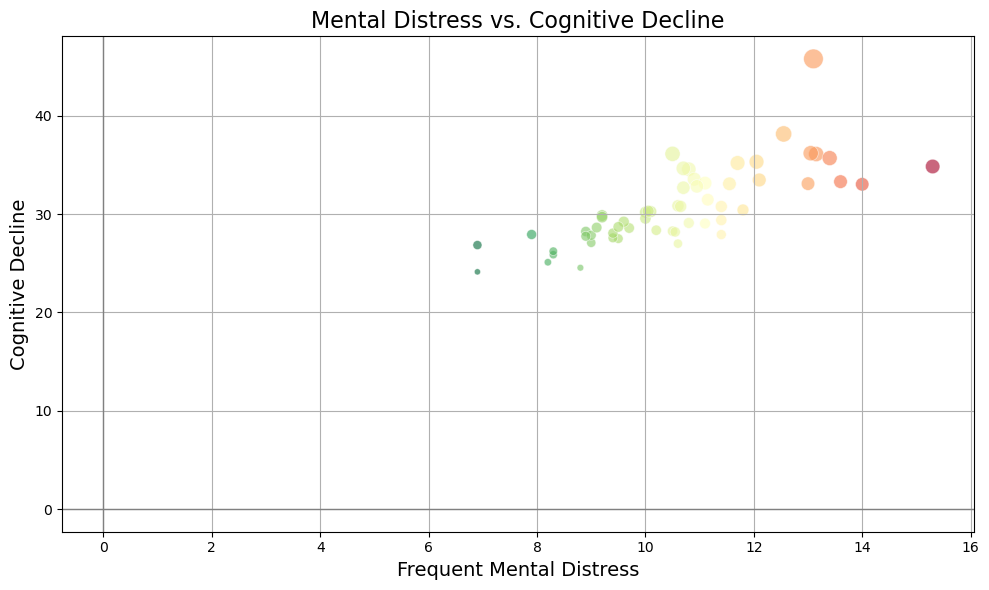

In [35]:
# Assuming Relationship_df is your DataFrame containing the data
valid_data = Relationship_df.dropna(subset=['Avg_Mental_Distress', 'Avg_Cognitive_Decline'])

# Set up the plot
plt.figure(figsize=(10, 6))

# Create a scatter plot with color gradient and no legend or color bar
sns.scatterplot(
    data=valid_data,
    x='Avg_Mental_Distress',
    y='Avg_Cognitive_Decline',
    hue='Avg_Mental_Distress',
    palette='RdYlGn_r',  # Red to Green gradient
    size='Avg_Cognitive_Decline',  # Optional: Size of the points based on cognitive decline
    sizes=(20, 200),  # Adjust sizes of points
    alpha=0.6,  # Transparency
    edgecolor='w',
    legend=False  # Disable the legend box
)

# Add titles and labels
plt.title('Mental Distress vs. Cognitive Decline', fontsize=16)
plt.xlabel('Frequent Mental Distress', fontsize=14)
plt.ylabel('Cognitive Decline', fontsize=14)
plt.axhline(0, color='gray', lw=1)  # Add x-axis line
plt.axvline(0, color='gray', lw=1)  # Add y-axis line
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


<b> Insight(s): </b> There seems to be a moderate positive correlation between average mental distress and average cognitive decline. As mental distress increases, cognitive decline also tends to increase.

In [36]:
valid_data_cleaned = valid_data.dropna()
# One-Hot Encoding for the 'Location' column
valid_data_encoded = pd.get_dummies(valid_data_cleaned, columns=['Geolocation'])

In [40]:
print("OMP_NUM_THREADS:", os.environ.get('OMP_NUM_THREADS'))

OMP_NUM_THREADS: 1


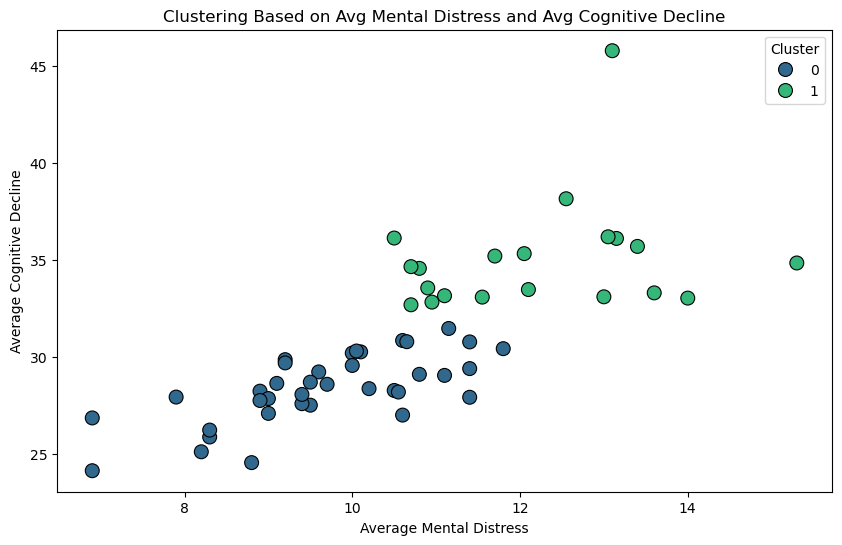

In [42]:
# Selecting only the numerical columns for clustering (excluding 'Location')
X = valid_data[['Avg_Mental_Distress', 'Avg_Cognitive_Decline']]

# Running KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust 'n_clusters' based on your need
valid_data['Cluster'] = kmeans.fit_predict(X)

# Plotting the clusters in a scatter plot
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='Avg_Mental_Distress',
    y='Avg_Cognitive_Decline',
    hue='Cluster',  # Coloring by clusters
    palette='viridis',
    data=valid_data,
    s=100,  # Point size
    marker='o',  # Shape of the points
    edgecolor='k'  # Black edges for points
)

plt.title('Clustering Based on Avg Mental Distress and Avg Cognitive Decline')
plt.xlabel('Average Mental Distress')
plt.ylabel('Average Cognitive Decline')

# Display the plot
plt.show()

In [45]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(X, valid_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.59


This Silhouette Score is generally considered good, indicating that the clusters are reasonably well-separated. 

### Interpretation

Cluster 0 is a low-risk group that constitutes 'Emotionally Stable & Cognitively Healthy individuals'. This suggests a population that copes well with stress and maintains cognitive abilities.

Cluster 1 comprises At-Risk Individuals. Focuses on those experiencing significant mental distress and cognitive issues.

## Concluding Remarks

From the analysis, we observe variations in cognitive decline based on gender, race/ethnicity, and age group across different regions. These insights help us understand the demographic disparities in cognitive health among older individuals. These insights can be used to create targeted interventions and healthcare strategies for high-risk demographics.

GridDB has proven to be instrumental in this analysis due to its efficient handling of large datasets and the ease of integrating with Python for advanced analytics. By leveraging GridDB’s high-performance capabilities, we could process and query vast amounts of health data quickly. GridDB's smooth handling of complex queries and fast retrieval times help us generate deep insights in near-real time.